In [3]:
!apt-get -y install ffmpeg
!pip -q install demucs librosa pyloudnorm soundfile numpy scipy matplotlib pipeline


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# 2) file upload

In [8]:
from google.colab import files
uploaded = files.upload()
list(uploaded)


KeyboardInterrupt: Interrupted by user

# 3) Run the full pipeline (no modules, all inline)

--2025-09-07 22:05:31--  https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3
Resolving www.soundhelix.com (www.soundhelix.com)... 81.169.145.157, 2a01:238:20a:202:1157::
Connecting to www.soundhelix.com (www.soundhelix.com)|81.169.145.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8945229 (8.5M) [audio/mpeg]
Saving to: ‘/content/user.mp3’

/content/user.mp3   100%[===================>]   8.53M  5.31MB/s    in 1.6s    

2025-09-07 22:05:34 (5.31 MB/s) - ‘/content/user.mp3’ saved [8945229/8945229]

--2025-09-07 22:05:34--  https://www.soundhelix.com/examples/mp3/SoundHelix-Song-2.mp3
Resolving www.soundhelix.com (www.soundhelix.com)... 81.169.145.157, 2a01:238:20a:202:1157::
Connecting to www.soundhelix.com (www.soundhelix.com)|81.169.145.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10222911 (9.7M) [audio/mpeg]
Saving to: ‘/content/ref.mp3’

/content/ref.mp3    100%[===================>]   9.75M  5.61MB/s    in 1.7

/tmp/ipython-input-3459644885.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"bpm": float(tempo), "drift_pct": float(iqr(ints)/med*100.0)}
/tmp/ipython-input-3459644885.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"bpm": float(tempo), "drift_pct": float(iqr(ints)/med*100.0)}


Recommendations (mix):
 • Your audio is ~5.9 dB louder than the reference.
 • More compression than reference. Ease bus compression/limiting.
 • Stereo image differs from the reference. Adjust widening/mono compatibility.


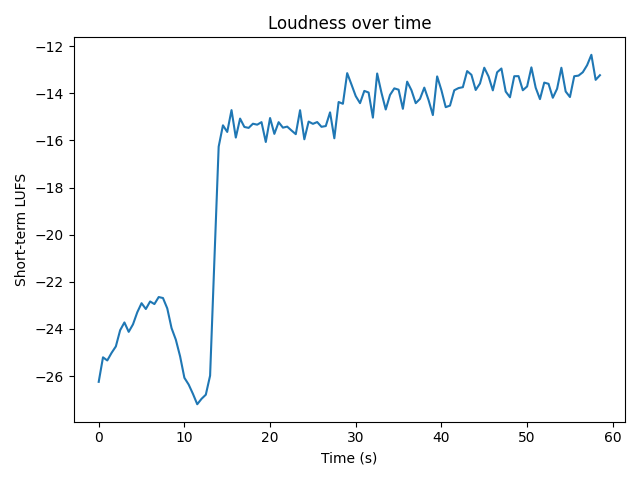

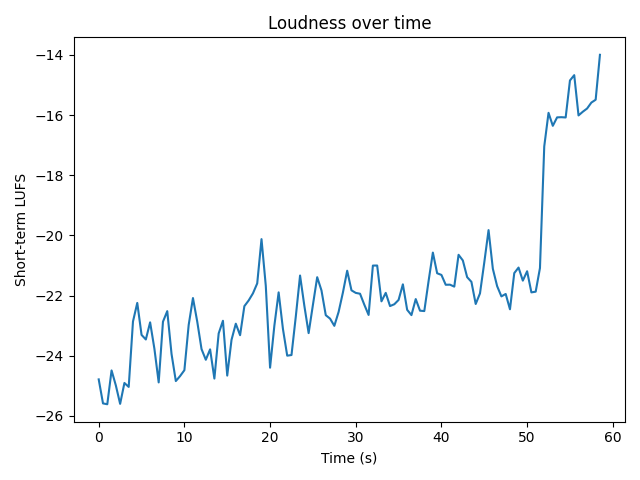

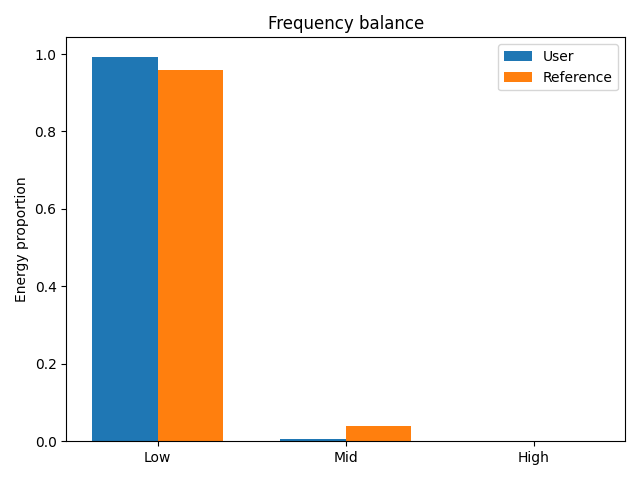

In [10]:
import os, uuid, subprocess, pathlib, numpy as np, librosa, pyloudnorm as pl
from scipy.stats import iqr
import matplotlib.pyplot as plt
from IPython.display import Image, display

CANON_SR = 48000
MAX_SEC  = 600

def load_audio(path, sr=CANON_SR, mono=False):
    y, sr = librosa.load(path, sr=sr, mono=mono)
    max_len = MAX_SEC * sr
    if y.ndim==1 and len(y)>max_len: y = y[:max_len]
    if y.ndim==2 and y.shape[1]>max_len: y = y[:, :max_len]
    return y, sr

def lufs_values(path):
    y, sr = load_audio(path, mono=True)
    meter = pl.Meter(sr)
    integ = float(meter.integrated_loudness(y))
    frame = int(sr*1.5); hop = max(1, frame//2)
    vals = [meter.integrated_loudness(y[i:i+frame]) for i in range(0, len(y)-frame, hop)]
    return {"integrated": integ,
            "short_term_mean": float(np.nanmean(vals) if vals else np.nan),
            "short_term_std": float(np.nanstd(vals) if vals else np.nan)}

def dynamic_range(path):
    y, sr = load_audio(path, mono=True)
    win = int(0.4*sr); hop = win//2
    rms = librosa.feature.rms(y=y, frame_length=win, hop_length=hop, center=False)[0]
    peak = np.array([np.max(np.abs(y[i:i+win])) for i in range(0, len(y)-win, hop)])
    # Ensure peak and rms have the same length
    min_len = min(len(peak), len(rms))
    peak = peak[:min_len]
    rms = rms[:min_len]
    eps=1e-9; dr = 20*np.log10((peak+eps)/(rms+eps))
    return {"dr_mean": float(np.mean(dr)),
            "dr_p25": float(np.percentile(dr,25)), "dr_p75": float(np.percentile(dr,75))}

def freq_balance(path):
    y, sr = load_audio(path, mono=True)
    S = np.abs(librosa.stft(y, n_fft=4096, hop_length=1024))**2
    freqs = librosa.fft_frequencies(sr=sr, n_fft=4096)
    bands = [(20,200), (200,5000), (5000,20000)]
    energy=[]
    for lo,hi in bands:
        idx = np.where((freqs>=lo)&(freqs<hi))[0]
        energy.append(float(np.mean(S[idx,:])) if idx.size else 0.0)
    total = sum(energy)+1e-9
    p = [e/total for e in energy]
    return {"low":p[0], "mid":p[1], "high":p[2]}

def stereo_width(path):
    y, sr = load_audio(path, mono=False)
    if y.ndim==1: return {"rho_mean":1.0, "rho_p10":1.0, "rho_p90":1.0}
    L,R = y[0], y[1]
    win = int(0.5*sr); hop = win//2; rhos=[]
    for i in range(0, L.shape[0]-win, hop):
        a,b = L[i:i+win], R[i:i+win]
        if np.std(a)<1e-8 or np.std(b)<1e-8: continue
        rhos.append(float(np.clip(np.corrcoef(a,b)[0,1], -1, 1)))
    return {"rho_mean": float(np.mean(rhos)),
            "rho_p10": float(np.percentile(rhos,10)),
            "rho_p90": float(np.percentile(rhos,90))}

def tempo_and_drift(path):
    y, sr = load_audio(path, mono=True)
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, units='time')
    if len(beats)<4: return {"bpm": float(tempo), "drift_pct": None}
    ints = np.diff(beats); med = np.median(ints)+1e-9
    return {"bpm": float(tempo), "drift_pct": float(iqr(ints)/med*100.0)}

def extract_all(path):
    return {"loudness": lufs_values(path),
            "dynrange": dynamic_range(path),
            "freqbal":  freq_balance(path),
            "width":    stereo_width(path),
            "tempo":    tempo_and_drift(path)}

def recs_for_pair(user, ref):
    out=[]
    dl = user["loudness"]["integrated"] - ref["loudness"]["integrated"]
    if abs(dl) >= 2.0:
        out.append(f"Your audio is ~{abs(dl):.1f} dB {'quieter' if dl<0 else 'louder'} than the reference.")
    ddr = user["dynrange"]["dr_mean"] - ref["dynrange"]["dr_mean"]
    if ddr <= -1.5: out.append("More compression than reference. Ease bus compression/limiting.")
    for k,label in [("low","low end (20–200 Hz)"),("mid","mids (200 Hz–5 kHz)"),("high","highs (5–20 kHz)")]:
        d = user["freqbal"][k] - ref["freqbal"][k]
        if abs(d)>=0.08: out.append(f"{label} differs by ~{abs(d)*100:.0f}%. Consider EQ {'reduction' if d>0 else 'boost'}.")
    drho = user["width"]["rho_mean"] - ref["width"]["rho_mean"]
    if abs(drho)>=0.10: out.append("Stereo image differs from the reference. Adjust widening/mono compatibility.")
    if user["width"]["rho_p10"] < -0.05: out.append("Potential phase issues (negative L/R correlation).")
    if user["tempo"]["drift_pct"] and ref["tempo"]["drift_pct"] and (user["tempo"]["drift_pct"]-ref["tempo"]["drift_pct"]>=5):
        out.append("Timing less consistent than reference. Tighten or quantize.")
    return out[:6]

def compare_all(user, ref):
    return {"mix": recs_for_pair(user["mix"], ref["mix"])}

def separate_demucs(in_path, out_dir, model="htdemucs"):
    outdir = pathlib.Path(out_dir); outdir.mkdir(parents=True, exist_ok=True)
    subprocess.run(["demucs","-n",model,"-o",str(outdir), in_path],
                   check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    base = pathlib.Path(in_path).stem
    stem_dir = next(outdir.glob(f"{model}/{base}"))
    stems = {"mix": in_path}
    for k in ["vocals","drums","bass","other"]:
        p = stem_dir/f"{k}.wav"
        if p.exists(): stems[k] = str(p)
    return stems

def plot_loudness_curve(path, out_png):
    y, sr = librosa.load(path, sr=None, mono=True)
    m = pl.Meter(sr)
    win = int(sr*1.0); hop = max(1, win//2)
    t, v = [], []
    for i in range(0, len(y)-win, hop):
        v.append(m.integrated_loudness(y[i:i+win])); t.append(i/sr)
    plt.figure(); plt.plot(t, v); plt.xlabel("Time (s)"); plt.ylabel("Short-term LUFS")
    plt.title("Loudness over time"); plt.tight_layout(); plt.savefig(out_png); plt.close()

def plot_freq_bars(user_props, ref_props, out_png):
    ind = np.arange(3); w=0.35
    plt.figure()
    plt.bar(ind,   [user_props["low"],user_props["mid"],user_props["high"]], width=w, label="User")
    plt.bar(ind+w, [ref_props["low"],ref_props["mid"],ref_props["high"]],   width=w, label="Reference")
    plt.xticks(ind+w/2, ["Low","Mid","High"]); plt.ylabel("Energy proportion")
    plt.legend(); plt.title("Frequency balance"); plt.tight_layout(); plt.savefig(out_png); plt.close()

# ---- Run end-to-end on your uploaded files ----
# Download two royalty-free sample songs (MP3)
!wget -O /content/user.mp3 https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3
!wget -O /content/ref.mp3  https://www.soundhelix.com/examples/mp3/SoundHelix-Song-2.mp3

# (Optional) Trim to 60s for speed
!ffmpeg -y -ss 0 -t 60 -i /content/user.mp3 -ac 2 -ar 48000 /content/user_60s.mp3
!ffmpeg -y -ss 0 -t 60 -i /content/ref.mp3  -ac 2 -ar 48000 /content/ref_60s.mp3

USER = "/content/user_60s.mp3"
REF  = "/content/ref_60s.mp3"


job = str(uuid.uuid4())
work = pathlib.Path(f"/content/tmp/{job}"); (work/"user").mkdir(parents=True, exist_ok=True); (work/"ref").mkdir(parents=True, exist_ok=True)

# Step 1: stems
u_stems = separate_demucs(USER, str(work/"user"))
r_stems = separate_demucs(REF,  str(work/"ref"))

# Step 2: features (mix-only for brevity; add stems similarly if you want)
def pack(stems, fallback):
    d = {"mix": extract_all(stems.get("mix", fallback))}
    return d
user_feats, ref_feats = pack(u_stems, USER), pack(r_stems, REF)

# Step 3: compare
recs = compare_all(user_feats, ref_feats)

# Step 4: plots
plots = {
    "loud_user": str(work/"loud_user.png"),
    "loud_ref":  str(work/"loud_ref.png"),
    "freqbars":  str(work/"freqbars.png"),
}
plot_loudness_curve(u_stems.get("mix", USER), plots["loud_user"])
plot_loudness_curve(r_stems.get("mix", REF),  plots["loud_ref"])
plot_freq_bars(user_feats["mix"]["freqbal"], ref_feats["mix"]["freqbal"], plots["freqbars"])

# Step 5: print recs + show plots
print("Recommendations (mix):")
for r in recs["mix"]:
    print(" •", r)

display(Image(filename=plots["loud_user"]))
display(Image(filename=plots["loud_ref"]))
display(Image(filename=plots["freqbars"]))

# actionable insights

In [11]:
# ---------- ACTIONABLE RECOMMENDATIONS (drop-in) ----------
def _clamp(v, lo, hi):
    return max(lo, min(hi, v))

def actionable_recs_for_pair(user, ref, context="music"):
    import numpy as np
    plan = []
    dl   = user["loudness"]["integrated"] - ref["loudness"]["integrated"]
    ddr  = user["dynrange"]["dr_mean"]    - ref["dynrange"]["dr_mean"]
    dlow = user["freqbal"]["low"]  - ref["freqbal"]["low"]
    dmid = user["freqbal"]["mid"]  - ref["freqbal"]["mid"]
    dhigh= user["freqbal"]["high"] - ref["freqbal"]["high"]
    drho = user["width"]["rho_mean"] - ref["width"]["rho_mean"]
    drift_u = user["tempo"]["drift_pct"]; drift_r = ref["tempo"]["drift_pct"]

    target_lufs = -14.0 if context == "music" else -16.0
    delta_vs_target = target_lufs - user["loudness"]["integrated"]
    if abs(delta_vs_target) >= 1.0:
        plan.append({"priority":0,"issue":"Overall loudness vs platform norms",
                     "why":f"Your integrated LUFS is {user['loudness']['integrated']:.1f}; typical target ~{target_lufs:.0f} LUFS.",
                     "do":"Align to platform target (after tonal/dynamics fixes).",
                     "settings":f"Adjust master gain {delta_vs_target:+.1f} dB; limiter ceiling ≈ -1.0 dBTP."})

    if abs(dl) >= 2.0:
        plan.append({"priority":1,"issue":"Loudness mismatch vs reference",
                     "why":f"Integrated LUFS differs by {dl:+.1f} dB.",
                     "do":"Trim master level to match the reference before fine EQ/comp.",
                     "settings":f"Master gain {(-dl):+.1f} dB (i.e., {'raise' if dl<0 else 'lower'} by {abs(dl):.1f} dB)."})
    else:
        st_std_u = user["loudness"]["short_term_std"]; st_std_r = ref["loudness"]["short_term_std"]
        if np.isfinite(st_std_u) and np.isfinite(st_std_r) and (st_std_u - st_std_r) >= 1.0:
            plan.append({"priority":2,"issue":"Inconsistent loudness over time",
                         "why":f"Short-term loudness varies more than the reference (+{st_std_u - st_std_r:.1f} dB std).",
                         "do":"Smooth with gentle bus compression or clip gain automation.",
                         "settings":"Bus comp: 1.5–2.5:1, attack 20–40 ms, release 100–200 ms, GR 1–3 dB."})

    if abs(dlow) >= 0.08:
        if dlow > 0:
            plan.append({"priority":3,"issue":"Excess low end vs reference",
                         "why":f"Low band is ~{dlow*100:.0f}% higher than reference.",
                         "do":"Tighten bass & kick; clean sub build-up.",
                         "settings":"Low-shelf −1 to −3 dB @ 80–120 Hz (Q≈0.7); HPF non-bass @ 60–90 Hz; optional sidechain bass to kick."})
        else:
            plan.append({"priority":3,"issue":"Thin low end vs reference",
                         "why":f"Low band is ~{abs(dlow)*100:.0f}% lower than reference.",
                         "do":"Add weight to bass/kick.",
                         "settings":"Low-shelf +1 to +2 dB @ 80–120 Hz (Q≈0.7). Ensure bass fundamental 50–80 Hz is present."})

    if abs(dmid) >= 0.08:
        if dmid > 0:
            plan.append({"priority":4,"issue":"Forward/boxy mids vs reference",
                         "why":f"Mids are ~{dmid*100:.0f}% higher than reference.",
                         "do":"Tame mud/boxiness or harsh presence.",
                         "settings":"−1 to −2 dB @ 250–400 Hz (mud) or −1 to −2 dB @ 2–4 kHz (harsh), Q≈0.7–1.0."})
        else:
            plan.append({"priority":4,"issue":"Recessed mids vs reference",
                         "why":f"Mids are ~{abs(dmid)*100:.0f}% lower than reference.",
                         "do":"Add presence/clarity.",
                         "settings":"+1 to +2 dB @ 1.5–3 kHz, Q≈0.7–1.0."})

    if abs(dhigh) >= 0.08:
        if dhigh > 0:
            plan.append({"priority":5,"issue":"Bright/top-heavy highs vs reference",
                         "why":f"High band is ~{dhigh*100:.0f}% higher than reference.",
                         "do":"Soften top; control sibilance.",
                         "settings":"High-shelf −1 to −2 dB @ 8–12 kHz; de-esser on vocals if needed."})
        else:
            plan.append({"priority":5,"issue":"Dull highs vs reference",
                         "why":f"High band is ~{abs(dhigh)*100:.0f}% lower than reference.",
                         "do":"Add air and sheen.",
                         "settings":"High-shelf +1 to +2 dB @ 10–14 kHz."})

    if ddr <= -1.5:
        plan.append({"priority":6,"issue":"Over-compressed vs reference",
                     "why":f"Crest/dynamic range is {abs(ddr):.1f} dB lower.",
                     "do":"Back off bus compression/limiting; regain punch.",
                     "settings":"Lower ratio/threshold; attack 20–40 ms; GR 1–3 dB; ease limiter input 0.5–1.5 dB."})
    elif ddr >= 1.5:
        plan.append({"priority":6,"issue":"Too dynamic vs reference",
                     "why":f"Crest/dynamic range is {ddr:.1f} dB higher.",
                     "do":"Gently tame peaks for cohesion.",
                     "settings":"1.5–2:1, attack 20–30 ms, release 100–200 ms, GR 1–2 dB."})

    if abs(drho) >= 0.10:
        if drho > 0:
            plan.append({"priority":7,"issue":"Narrower stereo vs reference",
                         "why":f"L/R correlation {drho:+.2f} higher (more mono).",
                         "do":"Widen safely; keep lows mono.",
                         "settings":"M/S: +1–2 dB Sides @ 4–8 kHz; keep <120 Hz mono; wideners 110–130% max."})
        else:
            plan.append({"priority":7,"issue":"Wider/phasey stereo vs reference",
                         "why":f"L/R correlation {drho:+.2f} lower.",
                         "do":"Tame width; check mono.",
                         "settings":"Reduce Sides −1–2 dB; ensure lows mono; avoid negative correlation."})
    if user["width"]["rho_p10"] < -0.05:
        plan.append({"priority":7,"issue":"Phase warning",
                     "why":"Negative L/R correlation detected in parts.",
                     "do":"Check polarity/time alignment; collapse lows to mono.",
                     "settings":"Flip polarity on suspect track; align DI/mic; mono <120 Hz."})

    if (drift_u is not None) and (drift_r is not None) and (drift_u - drift_r) >= 5:
        plan.append({"priority":8,"issue":"Timing consistency",
                     "why":f"Beat drift {drift_u:.1f}% vs ref {drift_r:.1f}%.",
                     "do":"Tighten rhythmic elements.",
                     "settings":"Quantize drums/bass; tighten edits; light transient shaping."})

    plan.sort(key=lambda x: x["priority"])
    return plan

def print_action_plan(plan, top_k=8):
    print("\n=== Action Plan (most impactful first) ===")
    for i, step in enumerate(plan[:top_k], 1):
        print(f"{i}. {step['issue']}")
        print(f"   Why: {step['why']}")
        print(f"   Do:  {step['do']}")
        if step.get("settings"):
            print(f"   Try: {step['settings']}")


In [12]:
# Step 5: print recs + show plots
print("Recommendations (mix):")
for r in recs["mix"]:
    print(" •", r)


Recommendations (mix):
 • Your audio is ~5.9 dB louder than the reference.
 • More compression than reference. Ease bus compression/limiting.
 • Stereo image differs from the reference. Adjust widening/mono compatibility.



=== Action Plan (most impactful first) ===
1. Loudness mismatch vs reference
   Why: Integrated LUFS differs by +5.9 dB.
   Do:  Trim master level to match the reference before fine EQ/comp.
   Try: Master gain -5.9 dB (i.e., lower by 5.9 dB).
2. Over-compressed vs reference
   Why: Crest/dynamic range is 2.0 dB lower.
   Do:  Back off bus compression/limiting; regain punch.
   Try: Lower ratio/threshold; attack 20–40 ms; GR 1–3 dB; ease limiter input 0.5–1.5 dB.
3. Narrower stereo vs reference
   Why: L/R correlation +0.17 higher (more mono).
   Do:  Widen safely; keep lows mono.
   Try: M/S: +1–2 dB Sides @ 4–8 kHz; keep <120 Hz mono; wideners 110–130% max.


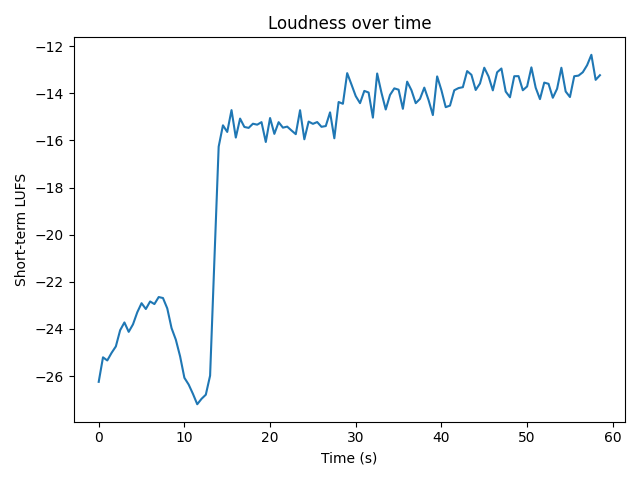

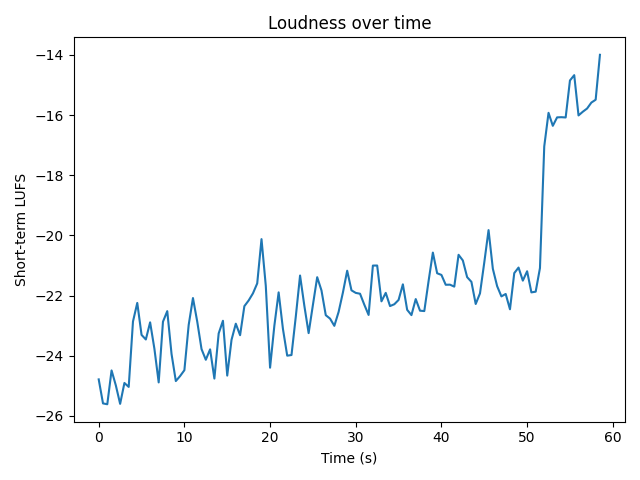

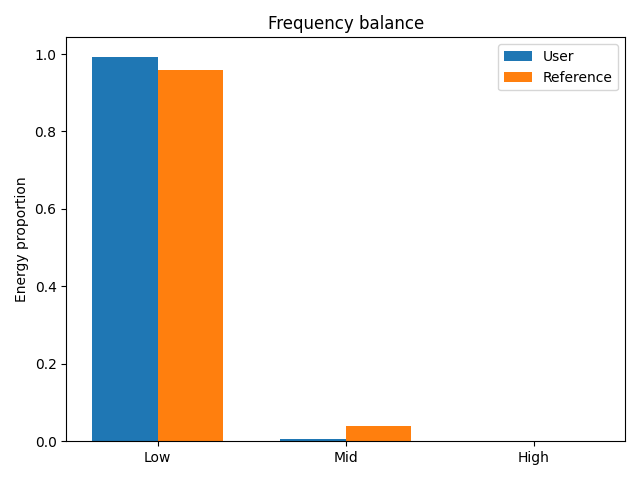

In [13]:
# Step 5: action-plan + plots
plan = actionable_recs_for_pair(user_feats["mix"], ref_feats["mix"], context="music")  # or "podcast"
print_action_plan(plan, top_k=8)

display(Image(filename=plots["loud_user"]))
display(Image(filename=plots["loud_ref"]))
display(Image(filename=plots["freqbars"]))


In [14]:
for s in ["mix","vocals","drums","bass","other"]:
    if s in user_feats and s in ref_feats:
        print(f"\n### {s.upper()} ###")
        plan = actionable_recs_for_pair(user_feats[s], ref_feats[s], context="music")
        print_action_plan(plan, top_k=6)



### MIX ###

=== Action Plan (most impactful first) ===
1. Loudness mismatch vs reference
   Why: Integrated LUFS differs by +5.9 dB.
   Do:  Trim master level to match the reference before fine EQ/comp.
   Try: Master gain -5.9 dB (i.e., lower by 5.9 dB).
2. Over-compressed vs reference
   Why: Crest/dynamic range is 2.0 dB lower.
   Do:  Back off bus compression/limiting; regain punch.
   Try: Lower ratio/threshold; attack 20–40 ms; GR 1–3 dB; ease limiter input 0.5–1.5 dB.
3. Narrower stereo vs reference
   Why: L/R correlation +0.17 higher (more mono).
   Do:  Widen safely; keep lows mono.
   Try: M/S: +1–2 dB Sides @ 4–8 kHz; keep <120 Hz mono; wideners 110–130% max.
